In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,0.0,0.0,NaN,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,0.0,0.0,0.0,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
38635,NaN,NaN,International,2020-08-19,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38636,NaN,NaN,International,2020-08-20,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38637,NaN,NaN,International,2020-08-21,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Albania', 'Andorra',
       'United Arab Emirates', 'Argentina', 'Armenia',
       'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Bonaire Sint Eustatius and Saba',
       'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada', 'Switzerland', 'Chile',
       'China', "Cote d'Ivoire", 'Cameroon',
       'Democratic Republic of Congo', 'Congo', 'Colombia', 'Comoros',
       'Cape Verde', 'Costa Rica', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Dominica',
       'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt',
       'Eritrea', 'Western Sahara', 'Spain', 'Estonia', 'Ethiopia',
       'Finland', 'Fiji', 'Falkland Islands', 'France',

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


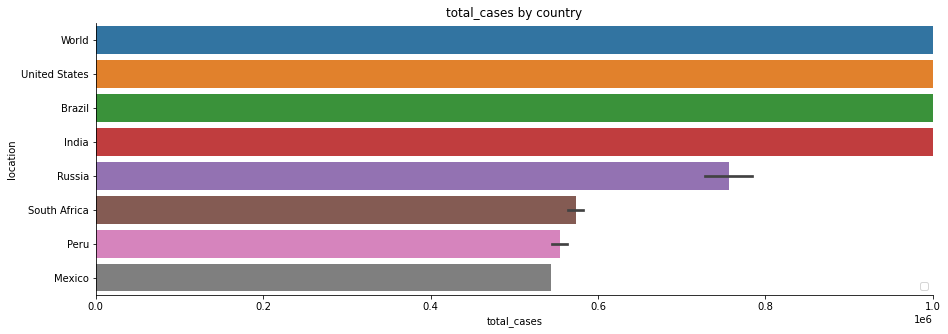

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


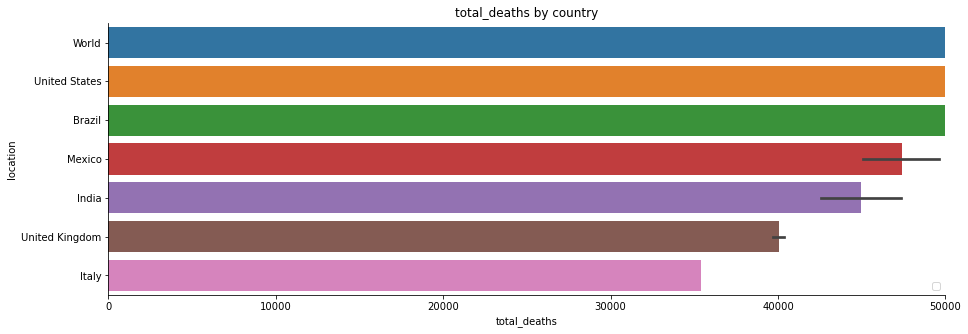

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


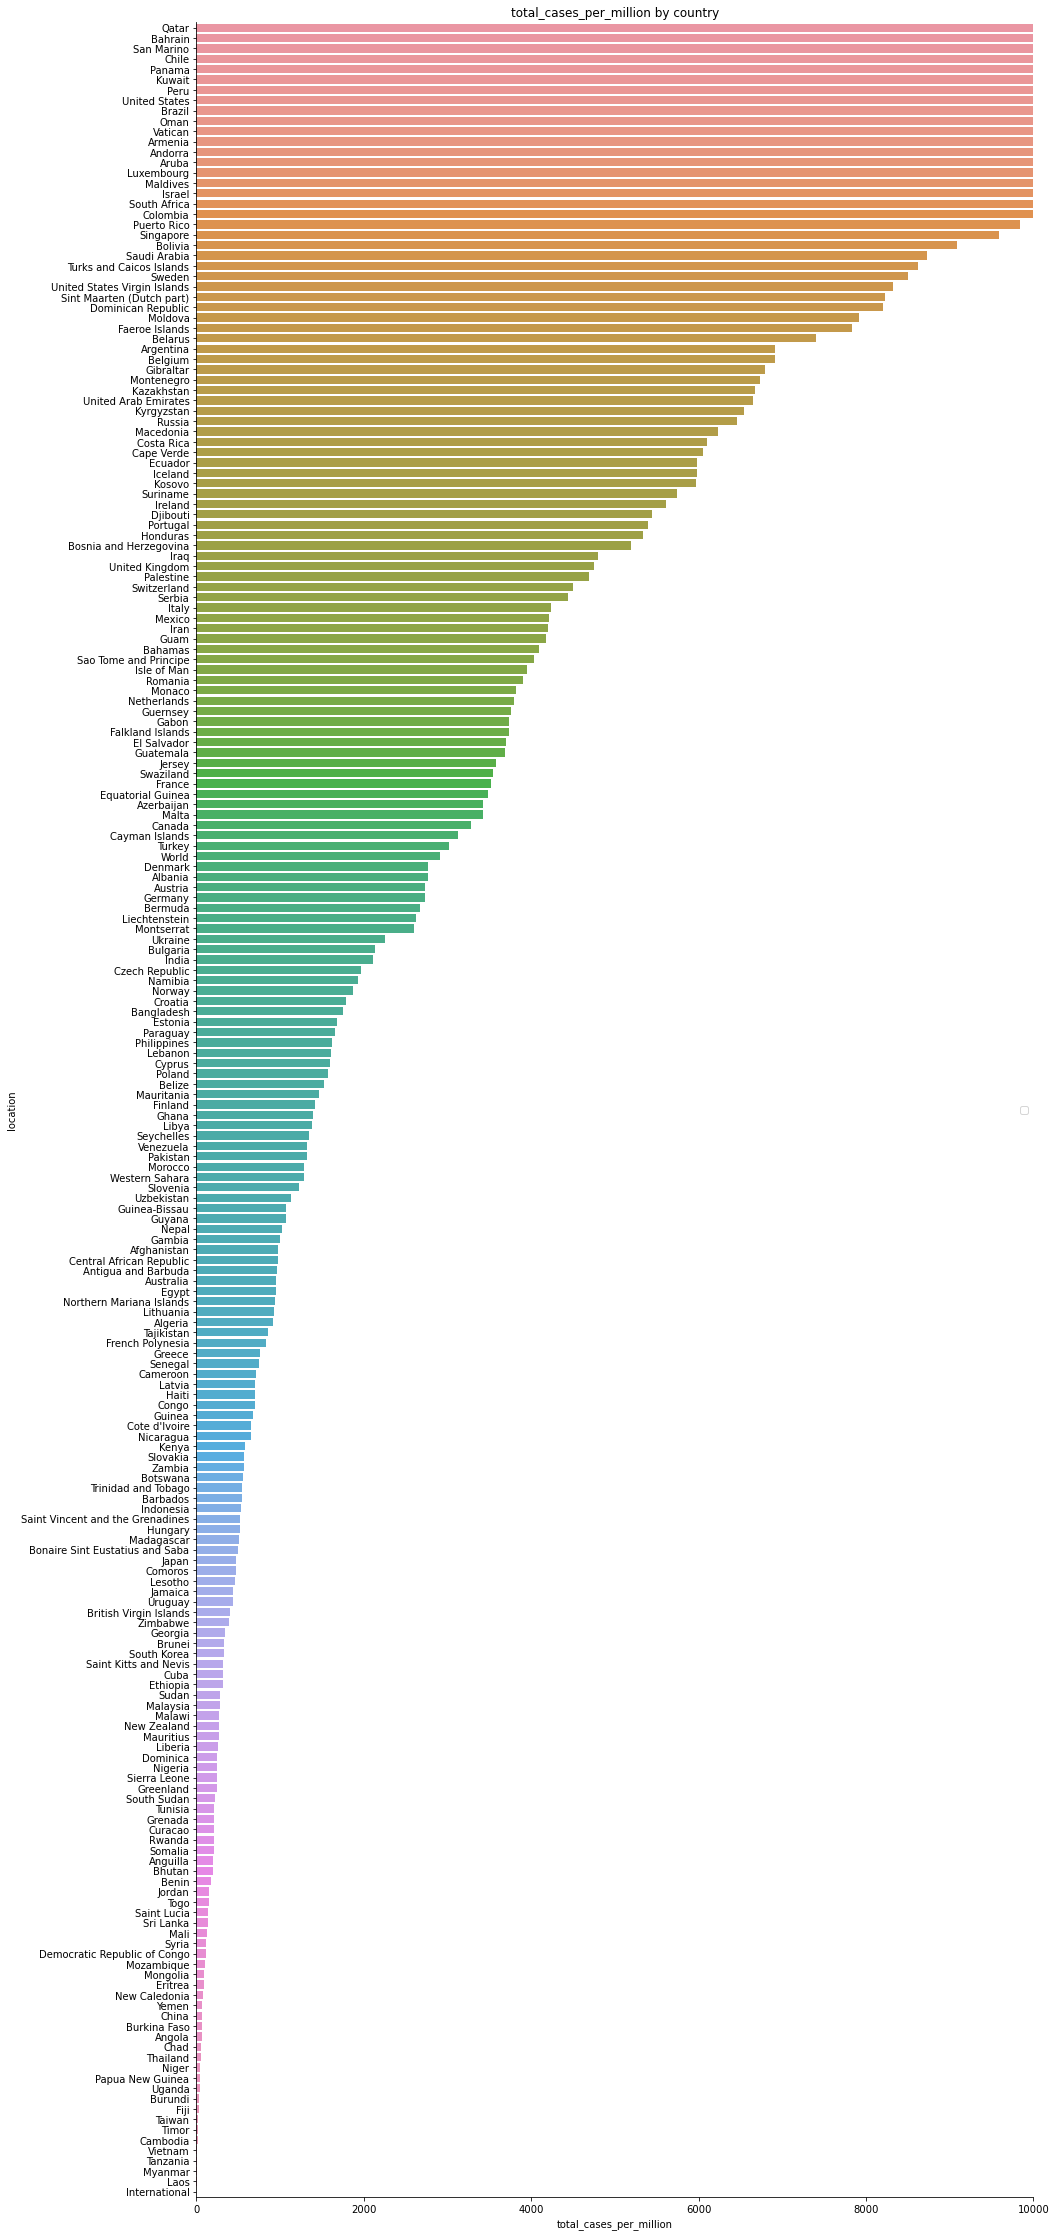

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


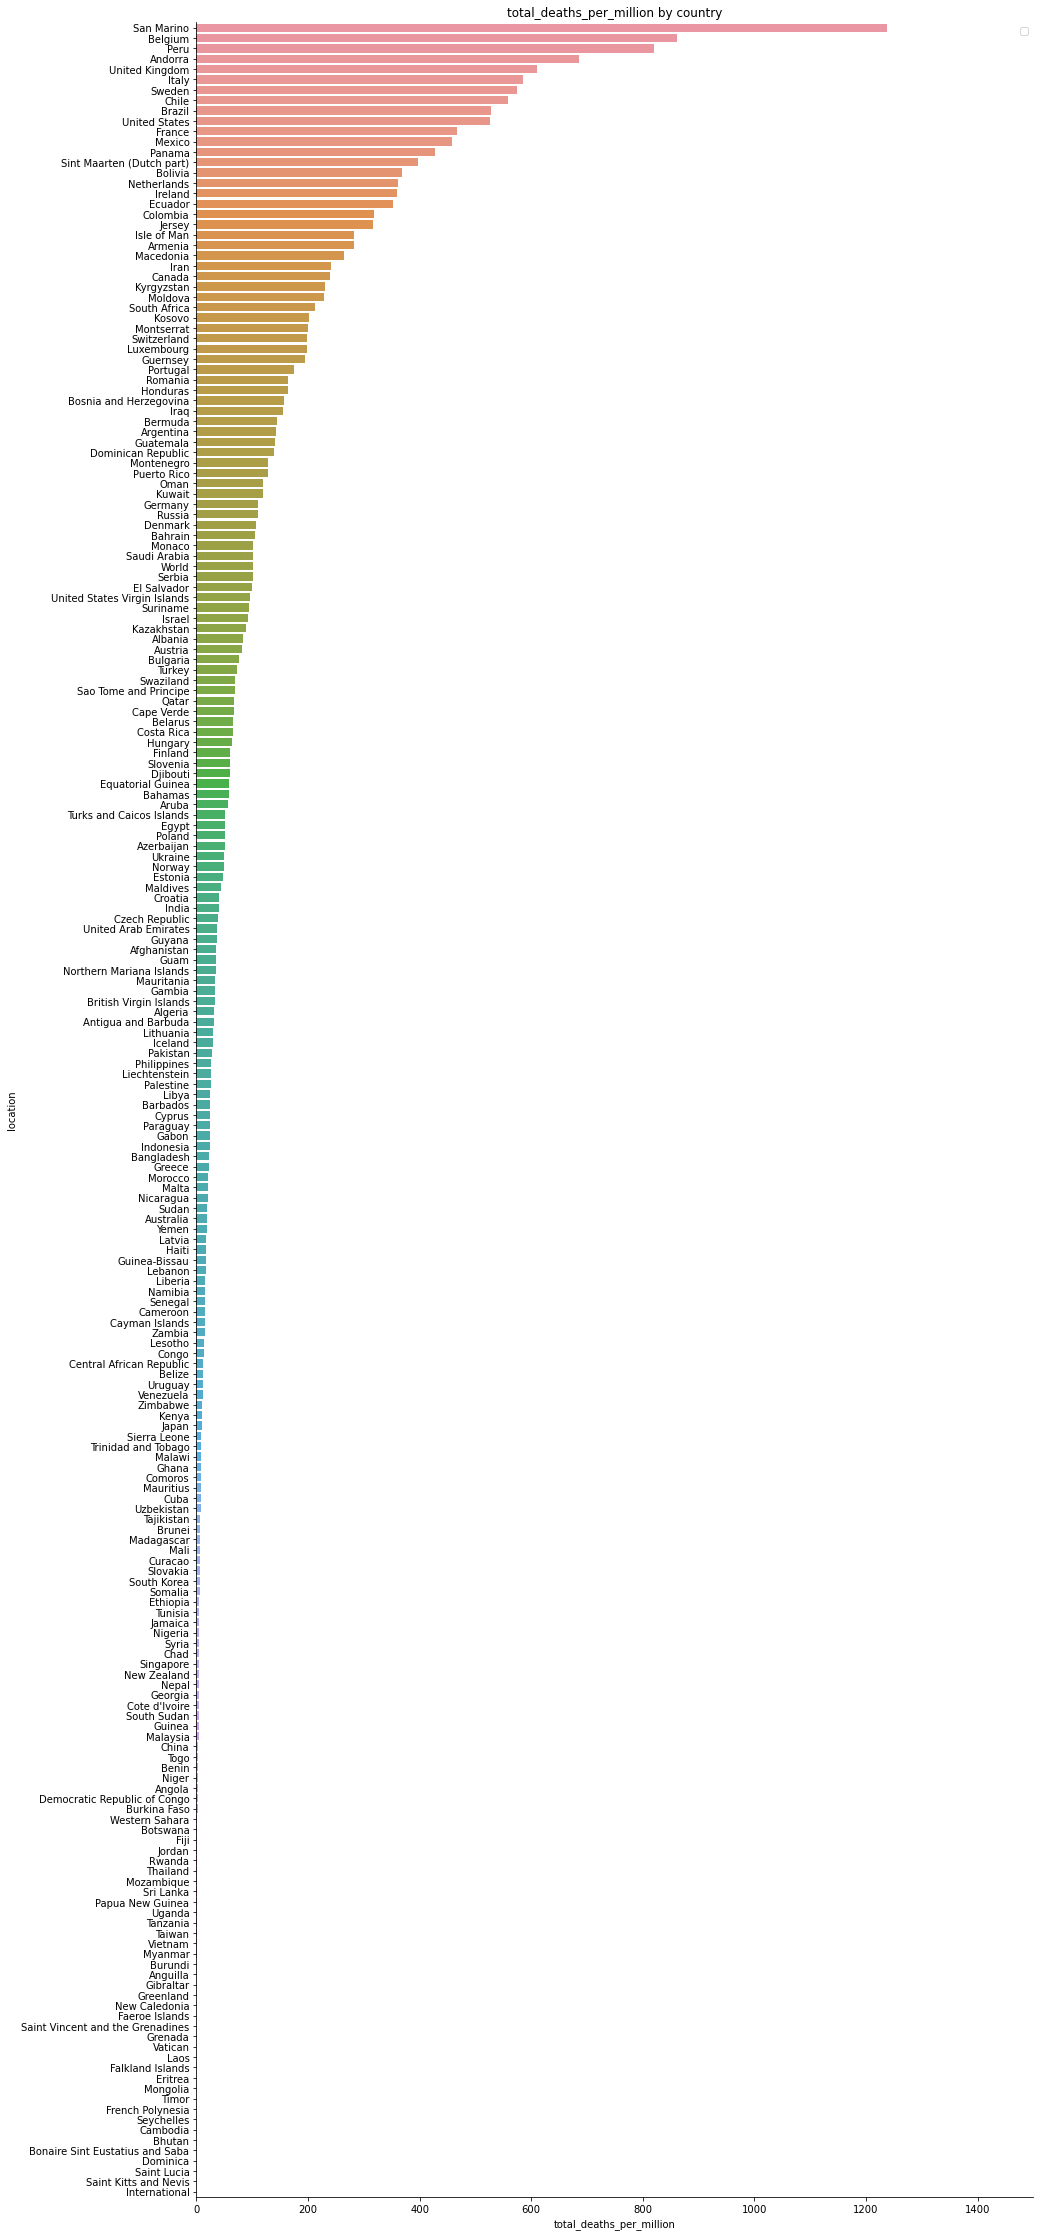

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

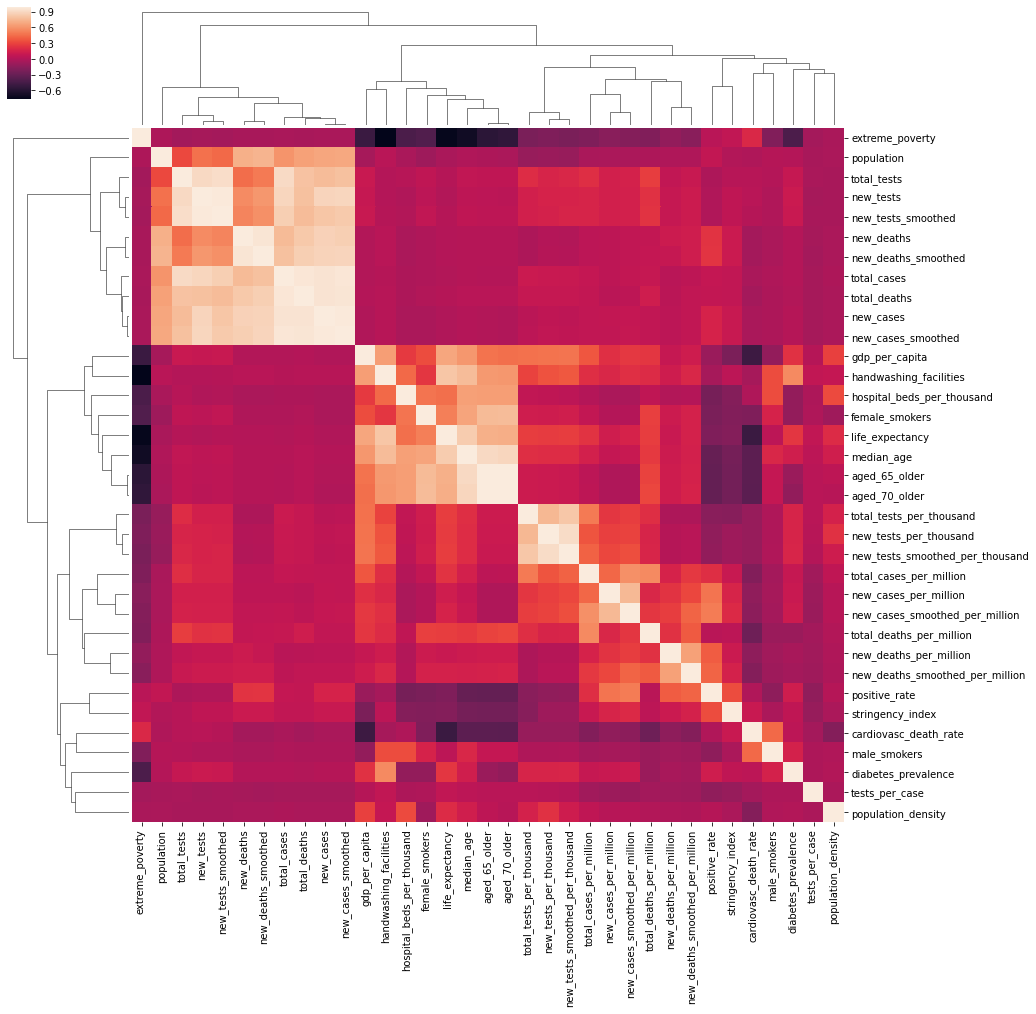

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9995686992745991 (+/- 0.0002000490154594937)
Coef :  [1.04112042e+00 8.83644584e-05 9.27328961e-05]
3 Last_days :  [[22159246 22439766 22705645]]
Today :  22705645
Prediction + :  439843
Tomorow :  23145488
                                     
--------- Total Death -----------------
                                     
R^2: 0.9994786758319584 (+/- 0.00022378593037907944)
Coef :  [-0.05173773  0.51307335  0.54873098]
3 Last_days :  [[781261 787794 794104]]
Today :  794104
Prediction + :  7648
Tomorow :  801752
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9785139236237755 (+/- 0.0222233631485492)
Coef :  [-0.66694679  0.72475369  0.94344181]
3 Last_days :  [[221267 225043 229814]]
Today :  229814
Prediction + :  2822
Tomorow :  232636
                                     
--------- Total Death -----------------
                                     
R^2: 0.40891946521239 (+/- 0.8244110331340332)
Coef :  [-0.75461999  0.78847388  0.96524934]
3 Last_days :  [[30451 30468 30480]]
Today :  30480
Prediction + :  36
Tomorow :  30516
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8278706704814357 (+/- 0.12286223092944898)
Coef :  [-0.3223767  -0.02393205  1.34057951]
3 Last_days :  [[89494 89527 89567]]
Today :  89567
Prediction + :  39
Tomorow :  89606
                                     
--------- Total Death -----------------
                                     
R^2: -1026.219969404381 (+/- 1452.4746306317568)
Coef :  [-0.07668845  0.01241929  1.0562842 ]
3 Last_days :  [[4705 4706 4709]]
Today :  4709
Prediction + :  7
Tomorow :  4716
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.7676513704055395 (+/- 0.3272154024145377)
Coef :  [-0.8350435   0.90369554  0.93056076]
3 Last_days :  [[254636 255278 256118]]
Today :  256118
Prediction + :  650
Tomorow :  256768
                                     
--------- Total Death -----------------
                                     
R^2: 0.9415383093858405 (+/- 0.05553688765755378)
Coef :  [-0.83370407  0.90209375  0.93079448]
3 Last_days :  [[35405 35412 35418]]
Today :  35418
Prediction + :  28
Tomorow :  35446
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6817708724693735 (+/- 0.43902400907888983)
Coef :  [-0.69879113  0.57544206  1.12392511]
3 Last_days :  [[364196 370867 377906]]
Today :  377906
Prediction + :  5996
Tomorow :  383902
                                     
--------- Total Death -----------------
                                     
R^2: 0.19844214856566267 (+/- 0.947433286429844)
Coef :  [-0.71909383  0.61263975  1.10548461]
3 Last_days :  [[28670 28797 28813]]
Today :  28813
Prediction + :  102
Tomorow :  28915
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9961262404738024 (+/- 0.005073181193805871)
Coef :  [0.07774961 0.46561626 0.4753616 ]
3 Last_days :  [[5482416 5529842 5573847]]
Today :  5573847
Prediction + :  88262
Tomorow :  5662109
                                     
--------- Total Death -----------------
                                     
R^2: 0.4835662377700654 (+/- 0.7287380695082774)
Coef :  [-0.60989621  0.76039345  0.8518611 ]
3 Last_days :  [[171821 173177 174255]]
Today :  174255
Prediction + :  1339
Tomorow :  175594
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9962002645485956 (+/- 0.004379059671598218)
Coef :  [-0.77630524  0.87441841  0.90196761]
3 Last_days :  [[320286 321098 322280]]
Today :  322280
Prediction + :  981
Tomorow :  323261
                                     
--------- Total Death -----------------
                                     
R^2: 0.44302229239332996 (+/- 0.7638559141345563)
Coef :  [-0.7762462   0.83272251  0.94302229]
3 Last_days :  [[41381 41397 41403]]
Today :  41403
Prediction + :  51
Tomorow :  41454
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9920237226047487 (+/- 0.008582170756865445)
Coef :  [-0.81099545  0.8664743   0.94406585]
3 Last_days :  [[226914 228621 228621]]
Today :  228621
Prediction + :  1577
Tomorow :  230198
                                     
--------- Total Death -----------------
                                     
R^2: 0.4429305447648009 (+/- 0.7753494166135618)
Coef :  [-0.79590804  0.84236448  0.95293515]
3 Last_days :  [[9243 9253 9253]]
Today :  9253
Prediction + :  15
Tomorow :  9268
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.4102277038597668 (+/- 0.8333821480653553)
Coef :  [0.18064914 0.41431781 0.41764901]
3 Last_days :  [[347835 347835 352558]]
Today :  352558
Prediction + :  2863
Tomorow :  355421
                                     
--------- Total Death -----------------
                                     
R^2: 0.8808079138897419 (+/- 0.16819739446016427)
Coef :  [-0.01988895  0.51598075  0.51764947]
3 Last_days :  [[19972 19972 20264]]
Today :  20264
Prediction + :  176
Tomorow :  20440
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9986235218542739 (+/- 0.0016715532835100118)
Coef :  [-0.75516899  0.85650032  0.89589308]
3 Last_days :  [[251805 253108 254520]]
Today :  254520
Prediction + :  1115
Tomorow :  255635
                                     
--------- Total Death -----------------
                                     
R^2: 0.999275537510736 (+/- 0.0007114661135998595)
Coef :  [-0.82043896  0.89931097  0.91813142]
3 Last_days :  [[6016 6039 6058]]
Today :  6058
Prediction + :  20
Tomorow :  6078
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.46837863029924076 (+/- 0.7488838467239224)
Coef :  [-0.17950055  0.49746934  0.69989359]
3 Last_days :  [[3407354 3456652 3501975]]
Today :  3501975
Prediction + :  61999
Tomorow :  3563974
                                     
--------- Total Death -----------------
                                     
R^2: 0.5088932550249099 (+/- 0.6904883394936184)
Coef :  [-0.17947227  0.54593432  0.64683115]
3 Last_days :  [[109888 111100 112304]]
Today :  112304
Prediction + :  1486
Tomorow :  113790
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(22705645, 794104, 23145488, 801752),
 (229814, 30480, 232636, 30516),
 (256118, 35418, 256768, 35446),
 (377906, 28813, 383902, 28915),
 (5573847, 174255, 5662109, 175594),
 (89567, 4709, 89606, 4716),
 (322280, 41403, 323261, 41454),
 (228621, 9253, 230198, 9268),
 (352558, 20264, 355421, 20440),
 (254520, 6058, 255635, 6078),
 (3501975, 112304, 3563974, 113790)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-08-21,France,232636.0,0.0,30516.0,0.0,0.0,0.0
0,2020-08-21,China,89606.0,0.0,4716.0,0.0,0.0,0.0
0,2020-08-21,Italy,256768.0,0.0,35446.0,0.0,0.0,0.0
0,2020-08-21,Spain,383902.0,0.0,28915.0,0.0,0.0,0.0
0,2020-08-21,United States,5662109.0,0.0,175594.0,0.0,0.0,0.0
0,2020-08-21,World,23145488.0,0.0,801752.0,0.0,0.0,0.0
0,2020-08-21,United Kingdom,323261.0,0.0,41454.0,0.0,0.0,0.0
0,2020-08-21,Germany,230198.0,0.0,9268.0,0.0,0.0,0.0
0,2020-08-21,Iran,355421.0,0.0,20440.0,0.0,0.0,0.0
0,2020-08-21,Turkey,255635.0,0.0,6078.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")